<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   int64  
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 122.8+ KB
None
        PassengerId     Survived       Pclass                  Name   Sex  \
count   1309.000000  1309.000000  1309.000000                  1309  1309   
unique          NaN          NaN          NaN                  1307     2   
top  

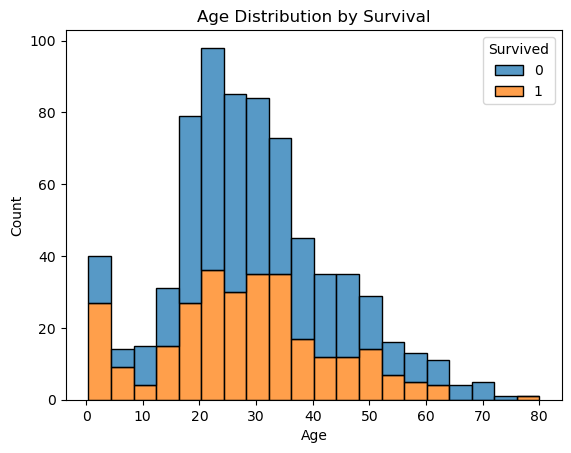

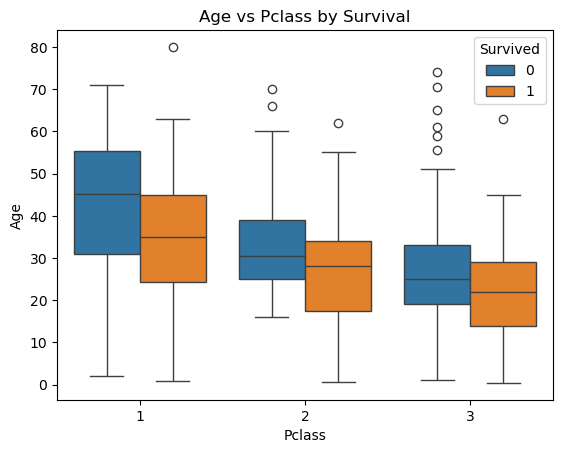

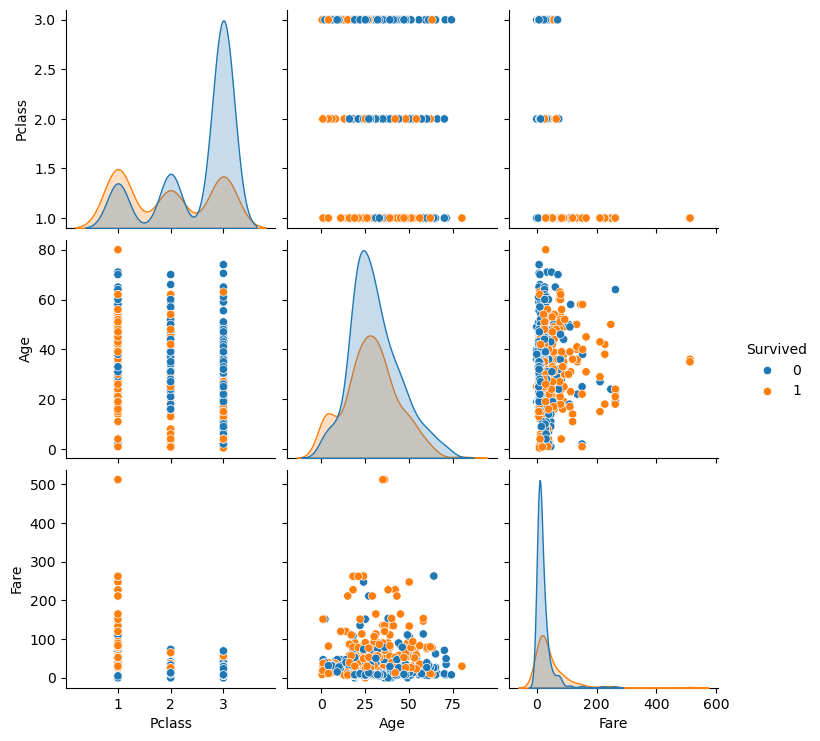

C:\Users\hp\AppData\Local\Temp\ipykernel_24584\1982018369.py:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df['Age'].fillna(combined_df['Age'].median(), inplace=True)
C:\Users\hp\AppData\Local\Temp\ipykernel_24584\1982018369.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 

Accuracy: 0.8101
Precision: 0.7857
Recall: 0.7432
F1 Score: 0.7639
ROC AUC Score: 0.8824


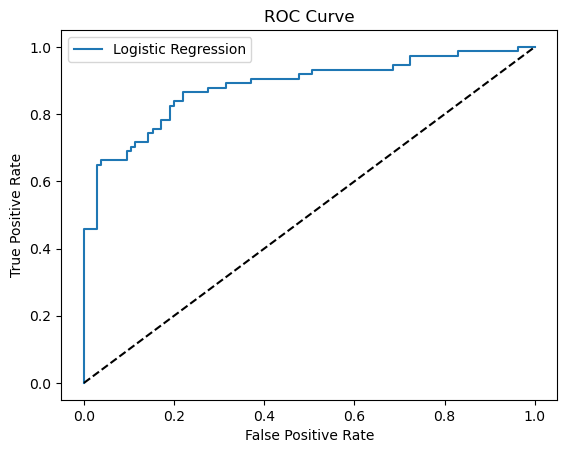

Feature Coefficients:
Fare        0.002534
Age        -0.030433
Parch      -0.111849
Embarked   -0.218778
SibSp      -0.293906
Pclass     -0.930679
Sex        -2.596996
dtype: float64
Pclass: Negative impact on survival
Sex: Negative impact on survival
Age: Negative impact on survival
SibSp: Negative impact on survival
Parch: Negative impact on survival
Fare: Positive impact on survival
Embarked: Negative impact on survival


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve
)
import pickle

# Load datasets
train_df = pd.read_csv(r"C:\Users\hp\Downloads\Logistic Regression\Logistic Regression\Titanic_train.csv")
test_df = pd.read_csv(r"C:\Users\hp\Downloads\Logistic Regression\Logistic Regression\Titanic_test.csv")

# Add Survived column to test and set to -1 as placeholder
test_df['Survived'] = -1

# Combine for consistent preprocessing
combined_df = pd.concat([train_df, test_df], sort=False)
combined_df.reset_index(drop=True, inplace=True)  # Fix duplicate index issue

# Data Exploration
print(combined_df.info())
print(combined_df.describe(include='all'))

# Visualizations
sns.histplot(data=combined_df[combined_df['Survived'] != -1], x='Age', hue='Survived', multiple='stack')
plt.title('Age Distribution by Survival')
plt.show()

sns.boxplot(data=combined_df[combined_df['Survived'] != -1], x='Pclass', y='Age', hue='Survived')
plt.title('Age vs Pclass by Survival')
plt.show()

sns.pairplot(train_df[['Survived', 'Pclass', 'Age', 'Fare']], hue='Survived')
plt.show()

# Handle missing values
combined_df['Age'].fillna(combined_df['Age'].median(), inplace=True)
combined_df['Embarked'].fillna(combined_df['Embarked'].mode()[0], inplace=True)
combined_df.drop(columns=['Cabin'], inplace=True)

# Encode categorical variables
label_encoders = {}
for column in ['Sex', 'Embarked']:
    le = LabelEncoder()
    combined_df[column] = le.fit_transform(combined_df[column])
    label_encoders[column] = le

# Drop non-informative columns
combined_df.drop(columns=['Name', 'Ticket', 'PassengerId'], inplace=True)

# Separate back into train and test sets
train_processed = combined_df[combined_df['Survived'] != -1].copy()
test_processed = combined_df[combined_df['Survived'] == -1].copy()

X_train = train_processed.drop(columns=['Survived'])
y_train = train_processed['Survived'].astype(int)
X_test = test_processed.drop(columns=['Survived'])

# Split training data for validation
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Train logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_tr, y_tr)

# Predictions
y_pred = model.predict(X_val)
y_prob = model.predict_proba(X_val)[:, 1]

# Evaluation metrics
print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print(f"Precision: {precision_score(y_val, y_pred):.4f}")
print(f"Recall: {recall_score(y_val, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_val, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_val, y_prob):.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
plt.plot(fpr, tpr, label='Logistic Regression')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Coefficient interpretation
coefficients = pd.Series(model.coef_[0], index=X_train.columns)
print("Feature Coefficients:")
print(coefficients.sort_values(ascending=False))

# Interpret direction
for feature, coef in coefficients.items():
    print(f"{feature}: {'Positive' if coef > 0 else 'Negative'} impact on survival")

# Save model
with open('logistic_model.pkl', 'wb') as file:
    pickle.dump(model, file)
